In [1]:
# required imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# for reading in the PyTorchVAE code
import sys
# sys.path.insert(0, 'drive/MyDrive/School/cs679/final/PyTorch-VAE')

from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor
Tensor = TypeVar('torch.tensor')
from abc import abstractmethod

# some initial env checks
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class BetaVAE(nn.Module):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self, in_channels=3, hidden_dims=[32, 64, 128, 256, 512], latent_dim=128,
                 beta: int = 4,
                 gamma:float = 10.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type = "beta",
                 kld_weight_corrector = 1.0):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter
        self.loss_type = loss_type
        self.kld_weight = kld_weight_corrector

        # Build Encoder
        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
            
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        # kld_weight = 0.00025  # Account for the minibatch samples from the dataset
        kld_weight = self.kld_weight

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'beta': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        else: # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [3]:
class DIPVAE(nn.Module):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = [32, 64, 128, 256, 512],
                 lambda_diag: float = 10.,
                 lambda_offdiag: float = 5.,
                 **kwargs) -> None:
        super(DIPVAE, self).__init__()

        self.latent_dim = latent_dim
        self.lambda_diag = lambda_diag
        self.lambda_offdiag = lambda_offdiag

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        # kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        kld_weight = 1
        recons_loss =F.mse_loss(recons, input, reduction='sum')


        kld_loss = torch.sum(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        # DIP Loss
        centered_mu = mu - mu.mean(dim=1, keepdim = True) # [B x D]
        cov_mu = centered_mu.t().matmul(centered_mu).squeeze() # [D X D]

        # Add Variance for DIP Loss II
        cov_z = cov_mu + torch.mean(torch.diagonal((2. * log_var).exp(), dim1 = 0), dim = 0) # [D x D]
        # For DIp Loss I
        # cov_z = cov_mu

        cov_diag = torch.diag(cov_z) # [D]
        cov_offdiag = cov_z - torch.diag(cov_diag) # [D x D]
        dip_loss = self.lambda_offdiag * torch.sum(cov_offdiag ** 2) + \
                   self.lambda_diag * torch.sum((cov_diag - 1) ** 2)

        loss = recons_loss + kld_weight * kld_loss + dip_loss
        return {'loss': loss,
                'Reconstruction_Loss':recons_loss,
                'KLD':-kld_loss,
                'DIP_Loss':dip_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

## Reading in Data & Setting Up Transforms

In [4]:
!gdown 1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ

Downloading...
From: https://drive.google.com/uc?id=1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ
To: /content/celeba.zip
100% 1.31G/1.31G [00:24<00:00, 52.5MB/s]


In [5]:
!unzip /content/celeba.zip

Archive:  /content/celeba.zip
   creating: celeba/
  inflating: celeba/img_align_celeba.zip  
  inflating: __MACOSX/celeba/._img_align_celeba.zip  
  inflating: celeba/list_attr_celeba.txt  
  inflating: __MACOSX/celeba/._list_attr_celeba.txt  
  inflating: celeba/.DS_Store        
  inflating: __MACOSX/celeba/._.DS_Store  
  inflating: celeba/list_bbox_celeba.txt  
  inflating: __MACOSX/celeba/._list_bbox_celeba.txt  
  inflating: celeba/list_landmarks_align_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_align_celeba.txt  
  inflating: celeba/list_landmarks_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_celeba.txt  
  inflating: celeba/list_eval_partition.txt  
  inflating: __MACOSX/celeba/._list_eval_partition.txt  
  inflating: celeba/identity_CelebA.txt  
  inflating: __MACOSX/celeba/._identity_CelebA.txt  


In [6]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CelebA
import zipfile
from torchvision.datasets import ImageFolder

# parameters taken from tuned BetaVAE
patch_size = 64
train_batch_size = 32
val_batch_size = 32

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(148),
                                      transforms.Resize(patch_size),
                                      transforms.ToTensor(),])

val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(148),
                                    transforms.Resize(patch_size),
                                    transforms.ToTensor(),])

# IMAGE_PATH = 'drive/MyDrive/School/cs679/final/Data/Data/celeba/img_align_celeba/'
# bypass = ImageFolder(IMAGE_PATH, train_transforms)
train_dataset = MyCelebA(
    "/content",
    split='train',
    transform=train_transforms,
    download=False,
)

val_dataset = MyCelebA(
    '/content',
    split='test',
    transform=val_transforms,
    download=False,
)

def train_dataloader(train_dataset, batch=train_batch_size) -> DataLoader:
    return DataLoader(
        train_dataset,
        batch_size=batch,
        num_workers=1,
        shuffle=True,
        pin_memory=True,
    )

def val_dataloader(val_dataset) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        num_workers=1,
        shuffle=False,
        pin_memory=True,
    )

def test_dataloader(val_dataset) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(
        val_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=True,
        pin_memory=True,
    )

In [7]:
!unzip -q /content/celeba/img_align_celeba.zip -d /content/celeba/

In [8]:
def configure_optimizer(model):
    optimizer = optim.Adam(model.parameters(),
                            lr=1e-3,
                            weight_decay=0.)
    
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                            gamma = 0.97)

    return optimizer, scheduler

In [9]:
DIPVAE_ANN = DIPVAE(in_channels = 3, 
                    latent_dim = 128,
                    hidden_dims = [32, 64, 128, 256, 512],
                    lambda_diag = 0.05,
                    lambda_offdiag = 0.1,
                    )

optimizer, scheduler = configure_optimizer(DIPVAE_ANN)
DIPVAE_ANN.to(device)

train_dl = train_dataloader(train_dataset)

In [24]:
for epoch in range(2):
    for idx, data in enumerate(tqdm(train_dl, 0)):
        imgs, labels = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        results = DIPVAE_ANN(imgs)

        train_loss = DIPVAE_ANN.loss_function(*results)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        train_loss['loss'].backward()
        optimizer.step()
    scheduler.step()

    print('Epoch {}: Loss {}'.format(epoch, train_loss))

100%|██████████| 5087/5087 [05:11<00:00, 16.32it/s]


Epoch 0: Loss {'loss': tensor(3705.4087, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(2641.0276, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(-923.6740, device='cuda:0', grad_fn=<NegBackward0>), 'DIP_Loss': tensor(140.7071, device='cuda:0', grad_fn=<AddBackward0>)}


100%|██████████| 5087/5087 [05:13<00:00, 16.22it/s]

Epoch 1: Loss {'loss': tensor(3615.1724, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(2557.2588, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(-934.7328, device='cuda:0', grad_fn=<NegBackward0>), 'DIP_Loss': tensor(123.1806, device='cuda:0', grad_fn=<AddBackward0>)}


In [36]:
test_dl = test_dataloader(val_dataset)

test_input, test_label = next(iter(test_dl))
test_input = test_input.to(device)
test_label = test_label.to(device)

recons = DIPVAE_ANN.generate(test_input, labels = test_label)

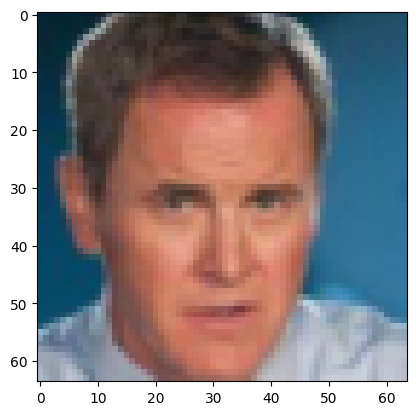

In [37]:
plt.imshow(  test_input[0].cpu().detach().permute(1, 2, 0)  )

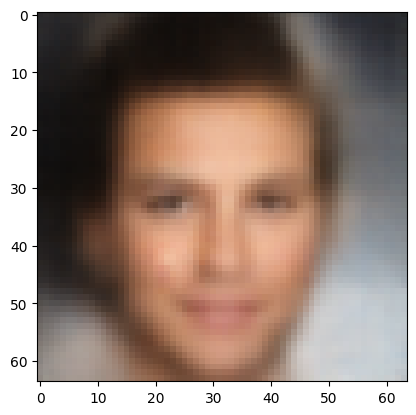

In [38]:
plt.imshow(  recons[0].cpu().detach().permute(1, 2, 0)  )

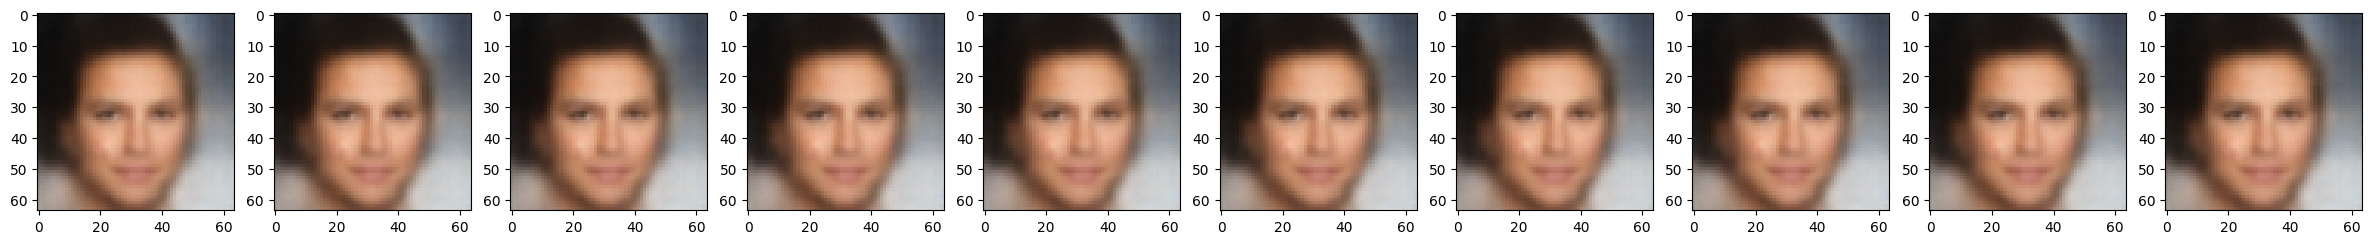

In [44]:
l_dim = 4
mu, log_var = DIPVAE_ANN.encode(test_input)
z = DIPVAE_ANN.reparameterize(mu, log_var)

f, axarr = plt.subplots(1,10, figsize=(30, 30))
count = 0
interpolation = torch.arange(-3., 3.1, 2/3)
for idx, perturbation in enumerate(interpolation):
  orig = z[:,l_dim]
  z[:,l_dim] = perturbation
  axarr[idx].imshow(  DIPVAE_ANN.decode(z)[0].cpu().detach().permute(1, 2, 0)  )
  z[:,l_dim] = orig

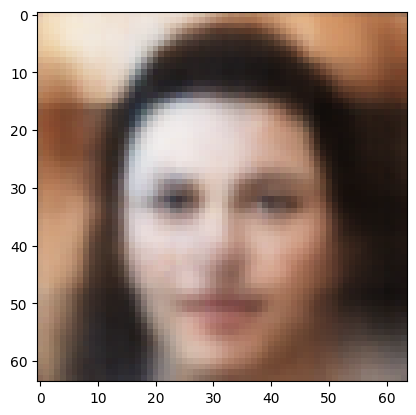

In [20]:
new_perp = DIPVAE_ANN.sample(1, device)
plt.imshow(  new_perp[0].cpu().detach().permute(1, 2, 0)  )

In [45]:
from torch.utils.data import Subset

smiling_idx = train_dataset.attr_names.index("Smiling")
smilers = np.where(train_dataset.attr[:, smiling_idx] == 1)[0]
not_smilers = np.where(train_dataset.attr[:, smiling_idx] == 0)[0].tolist()
smiling_dataset = Subset(train_dataset, smilers)
not_smiling_dataset = Subset(train_dataset, not_smilers)

smiling_dl = train_dataloader(smiling_dataset, batch=500)
not_smiling_dl = train_dataloader(not_smiling_dataset, batch=500)

smile_embeddings = torch.empty(size=(len(smiling_dl),128))
for idx, data in enumerate(tqdm(smiling_dl, 0)):
  imgs, labels = data
  imgs = imgs.to(device)

  # Feeding a batch of images into the network to obtain the output image, mu, and logVar
  results = DIPVAE_ANN.encode(imgs)
  z = DIPVAE_ANN.reparameterize(mu, log_var)
  smile_embeddings[idx,:] = torch.mean(z, dim=0)

smile_embeddings_avg = torch.mean(smile_embeddings, dim=0)

not_smile_embeddings = torch.empty(size=(len(not_smiling_dl),128))
for idx, data in enumerate(tqdm(not_smiling_dl, 0)):
  imgs, labels = data
  imgs = imgs.to(device)

  # Feeding a batch of images into the network to obtain the output image, mu, and logVar
  results = DIPVAE_ANN.encode(imgs)
  z = DIPVAE_ANN.reparameterize(mu, log_var)
  not_smile_embeddings[idx,:] = torch.mean(z, dim=0)

not_smile_embeddings_avg = torch.mean(not_smile_embeddings, dim=0)

smile_perturb = smile_embeddings_avg - not_smile_embeddings_avg

100%|██████████| 170/170 [02:10<00:00,  1.30it/s]


In [ ]:
# !pip install numba

# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [46]:
test_input, test_label = next(iter(smiling_dl))
test_input = test_input.to(device)
test_label = test_label.to(device)

mu, log_var = DIPVAE_ANN.encode(test_input)
z = DIPVAE_ANN.reparameterize(mu, log_var)
smiling_embeddings = torch.mean(z, dim=0)

test_input, test_label = next(iter(not_smiling_dl))
test_input = test_input.to(device)
test_label = test_label.to(device)

mu, log_var = DIPVAE_ANN.encode(test_input)
z = DIPVAE_ANN.reparameterize(mu, log_var)
not_smiling_embeddings = torch.mean(z, dim=0)

smile_perturbation = smiling_embeddings - not_smiling_embeddings

IndexError: ignored

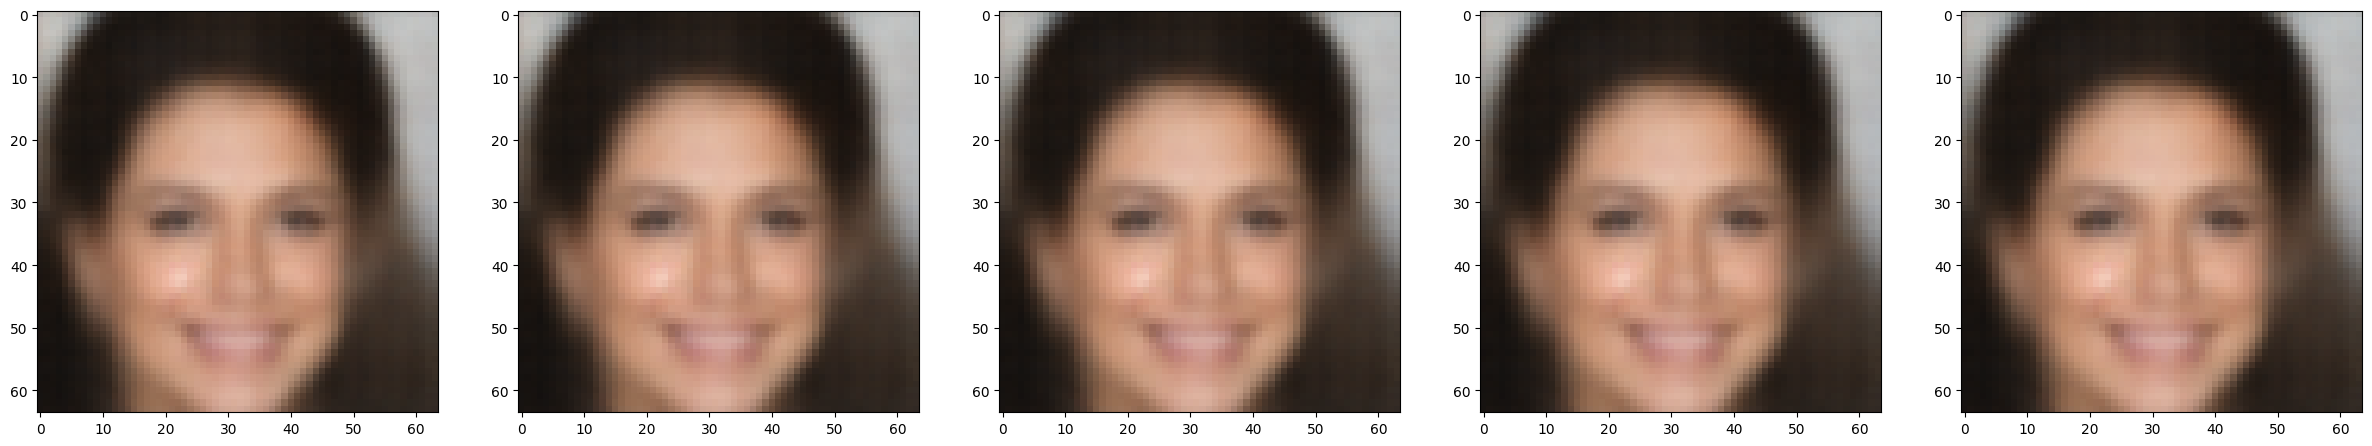

In [51]:
f, axarr = plt.subplots(1,5, figsize=(30, 30))

test_input, test_label = next(iter(test_dl))
test_input = test_input.to(device)
test_label = test_label.to(device)
mu, log_var = DIPVAE_ANN.encode(test_input)
z = DIPVAE_ANN.reparameterize(mu, log_var)

interpolation = torch.arange(-3., 3.0, 2/3)
for idx, perturbation in enumerate(interpolation):
  orig = z
  z = z + (perturbation * smile_perturb.to(device))
  axarr[idx].imshow(  DIPVAE_ANN.decode(z)[0].cpu().detach().permute(1, 2, 0)  )
  z = orig